<br>
<center style="color:#180090; font-weight: bold; font-size: 3em">Esercitazione 7</center><br>
<center style="color:#555555; font-size: 2em; margin-bottom: 0.2cm;">Francesco Righini</center>
<center style="color:#555555; font-size: 1.5em">(931984)</center>

In [1]:
# importazione librerie
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')
params = {'legend.fontsize': 'x-large', 'figure.figsize': (10, 6), 'axes.labelsize': 'x-large', 'axes.titlesize':'xx-large', 'xtick.labelsize':'x-large', 'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

<div style="color:#180090; font-size: 0.9cm; padding-top: 1em; font-weight:bold;">Esercizio 1</div>

<div style="color:#333333; font-size: 0.43cm; padding: 1em; background-color:#F5F5F5">
Usare il codice Monte Carlo NTV per stampare i valori istantanei di energia potenziale per particella e pressione nelle seguenti condizioni termodinamiche:
    
- stato solido: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- stato liquido: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- stato gassoso: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)
    
    
</div>

<div style="font-size: 0.43cm;">
Per ognuno dei tre stati si sono eseguite le simulazioni salvando, ad ogni timestep, l'energia potenziale e la pressione.
    
Nei grafici si sono divisi i primi $400$ step da tutti i seguenti, per permettere di visualizzare la breve fase di equilibrazione all'inizio di ogni simulazione.
</div>

In [2]:
# FUNZIONI GRAFICHE

def draw_U_P(energia,pressione,stato):

    fig, axs = plt.subplots(2,2,figsize=(16,14))
    x = np.arange(len(energia))

    ax = axs.flat[0]

    separazione = 400

    ax.plot(x[:separazione],energia[:separazione])
    ax.set_title("Energia potenziale [Stato "+stato+"]")
    ax.set_xlabel('# step')
    ax.set_ylabel(r'Energia / N [r.u.]')
    ax.grid(True)

    ax = axs.flat[1]

    ax.plot(x[separazione:],energia[separazione:])
    ax.set_title("Energia potenziale [Stato "+stato+"]")
    ax.set_xlabel('# step')
    ax.set_ylabel(r'Energia / N [r.u.]')
    ax.grid(True)

    ax = axs.flat[2]

    ax.plot(x[:separazione],pressione[:separazione])
    ax.set_title("Pressione [Stato "+stato+"]")
    ax.set_xlabel('# step')
    ax.set_ylabel(r'Pressione [r.u.]')
    ax.grid(True)


    ax = axs.flat[3]

    ax.plot(x[separazione:],pressione[separazione:])
    ax.set_title("Pressione [Stato "+stato+"]")
    ax.set_xlabel('# step')
    ax.set_ylabel(r'Pressione [r.u.]')
    ax.grid(True)

    return

def plot_autocorr(energia,pressione,stato):
    autocorr1 = autocorrelation(energia)
    plt.plot(autocorr1,label="energia potenziale")
    autocorr2 = autocorrelation(pressione)
    plt.plot(autocorr2,label="pressione")
    plt.hlines(np.exp(-2),0,max(len(autocorr1),len(autocorr2)),color="red",linestyle="dashed",label=r"$e^{-2}$")
    plt.title("Autocorrelazione [Stato "+stato+"]")
    plt.xlabel(r"$t$")
    plt.ylabel(r"$\chi(t)$")
    plt.legend()
    plt.show()
    return

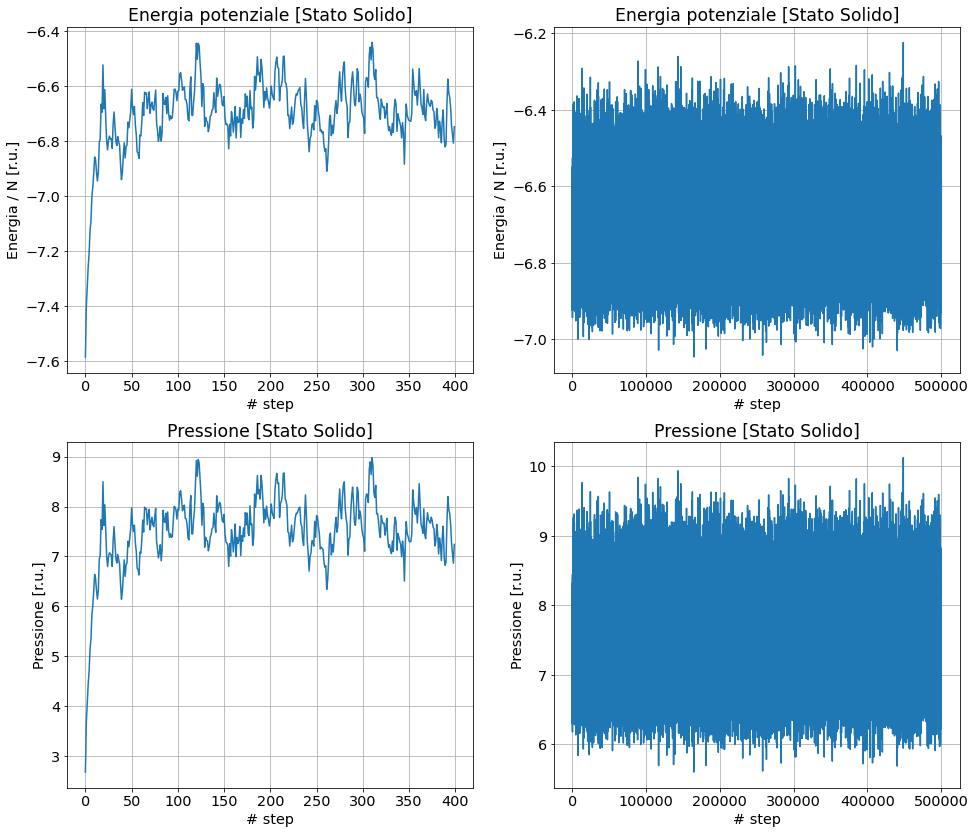

In [3]:
energia_s, pressione_s = np.loadtxt("results/see_sol.dat", usecols=(0,1), unpack='true')
draw_U_P(energia_s,pressione_s,"Solido")

<div style="font-size: 0.43cm;">
Nella simulazione dello stato solido l'equilibrazione dura poche decine di timestep: dal timestep $100$ si può considerare il sistema in equilibrio termodinamico.
</div>

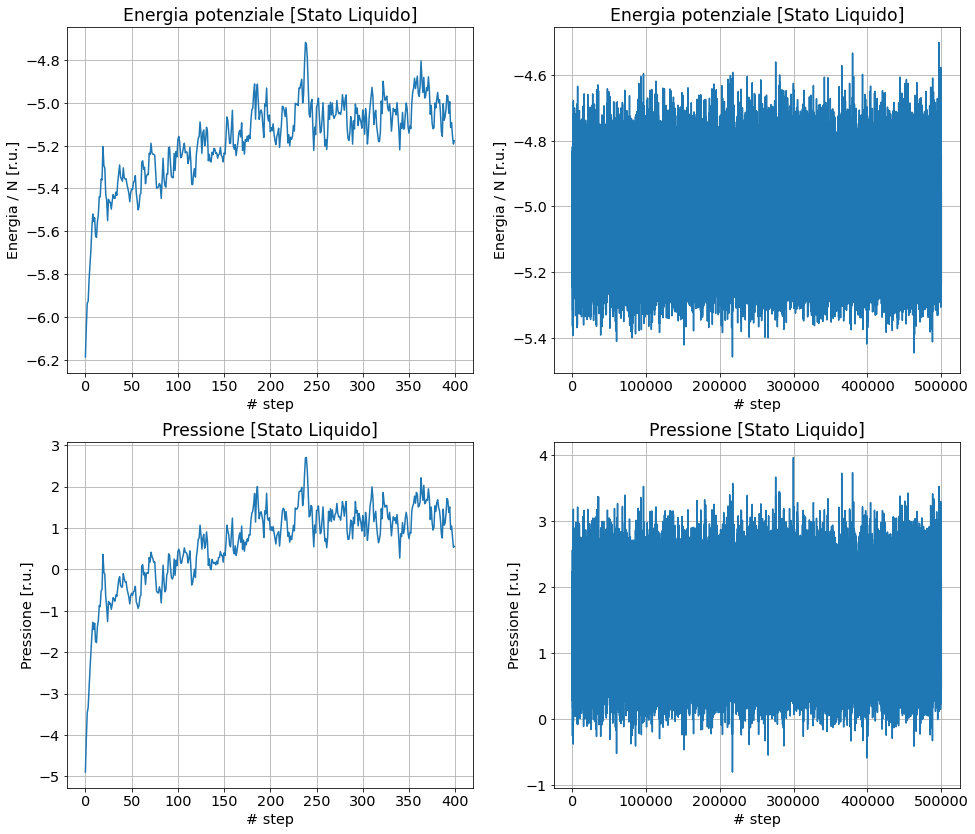

In [4]:
energia_l, pressione_l = np.loadtxt("results/see_liq.dat", usecols=(0,1), unpack='true')
draw_U_P(energia_l,pressione_l,"Liquido")

<div style="font-size: 0.43cm;">
Nella simulazione dello stato liquido l'equilibrazione dura più che nel caso dello stato solido. Dal timestep $250$ si può considerare il sistema in equilibrio termodinamico.
</div>

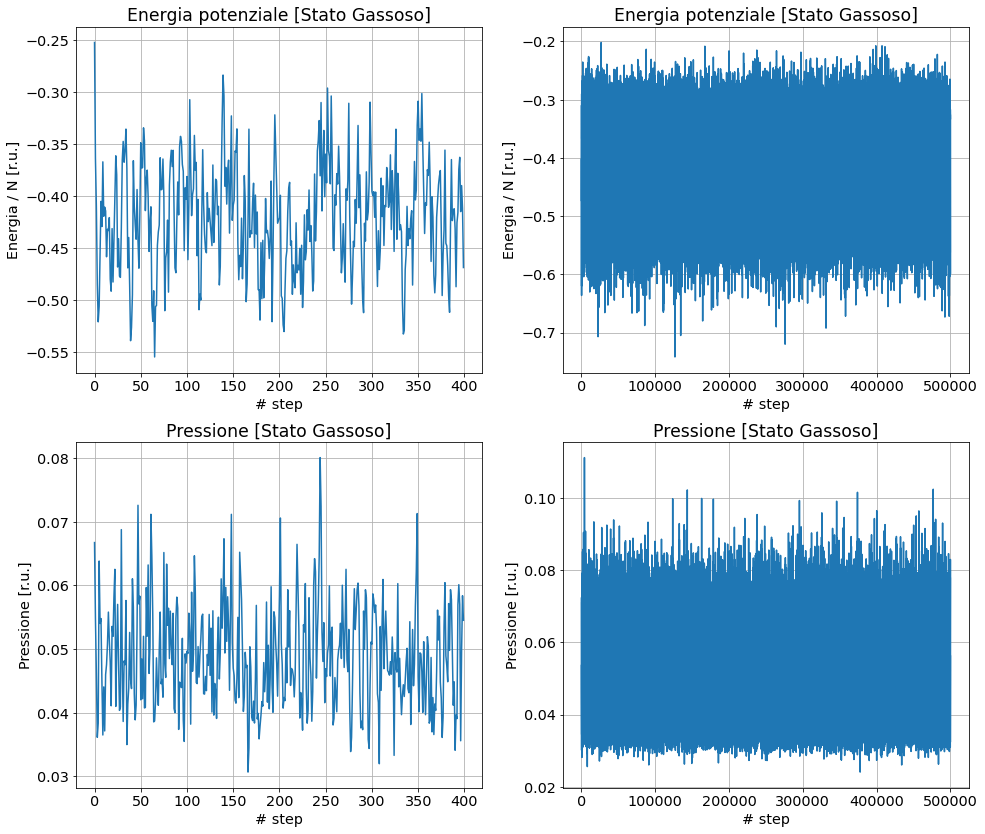

In [5]:
energia_g, pressione_g = np.loadtxt("results/see_gas.dat", usecols=(0,1), unpack='true')
draw_U_P(energia_g,pressione_g,"Gassoso")

<div style="font-size: 0.43cm;">
Nella simulazione dello stato gassoso l'equilibrazione è praticamente assente: fin dal principio si può considerare il sistema in equilibrio termodinamico.
</div>

<div style="color:#555555; font-size: 0.7cm; font-weight:bold;">Punto 1</div>

<div style="color:#333333; font-size: 0.43cm; padding: 1em; background-color:#F5F5F5">
Calcolare la funzione di autocorrelazione dell'energia potenziale per particella e pressione per stimare approssimativamente la dimensione corretta dei blocchi.
</div>

<div style="font-size: 0.43cm;">
La funzione di autocorrelazione di una serie $a(t)$ di lunghezza $T$ è definita come:
    
$$
\chi(t) = \dfrac{ \dfrac{1}{T-t} \sum_{t'=0}^{T-t} a(t')a(t'+t)  -  \dfrac{1}{T-t}\dfrac{1}{T-t} \sum_{t'=0}^{T-t} a(t') \sum_{t'=0}^{T-t} a(t'+t) }{    \dfrac{1}{T} \sum_{t'=0}^{T} a^2(t') - \left(  \dfrac{1}{T} \sum_{t'=0}^{T} a(t')   \right)^2    }.
$$
La funzione di autocorrelazione è valutabile per ogni $t<T$. Di seguito, però, ci si ferma nonappena la funzione di correlazione non scende sotto il valore di soglia $e^{-3}$ (sarebbe infatti inutile e decisamente dispendioso proseguire ad oltranza).
</div>

In [6]:
def autocorrelation(data):
    corr = 1
    result = [1]
    t_max = len(data)
    
    uno = 0
    due = 0
    
    for t_0 in range (t_max):
            uno = uno + data[t_0]**2
            due = due + data[t_0]
            
    den = (uno/t_max) - (due/t_max)**2
    print("varianza:",den)
    
    t = 0
    
    while corr > (1/np.e**3) :
        t = t + 1
        coeff = 1/(t_max-t)
        uno = 0
        due = 0
        tre = 0
        for t_0 in range (t_max-t):
            uno = uno + data[t_0]
            due = due + data[t_0 + t]
            tre = tre + (data[t_0 + t] * data[t_0])
        
        corr = (coeff*tre - coeff*uno*coeff*due) / den
        result.append(corr)
    
    return result

varianza: 0.007944983575015385
varianza: 0.244128601115996


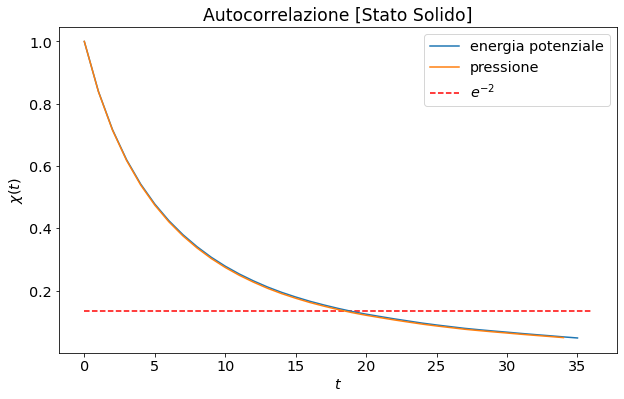

In [7]:
plot_autocorr(energia_s,pressione_s,"Solido")

<div style="font-size: 0.43cm;">
Nella simulazione dello stato solido, la correlazione scende sotto $e^{-2}$ nel giro di circa 20 timestep sia per la pressione che per l'energia potenziale. Prendere quindi blocchi con 20 o 30 misure delle variabili termodinamiche garantisce che i blocchi abbiano dei valori medi indipendenti.
</div>

varianza: 0.009744856907229149
varianza: 0.21790633751649913


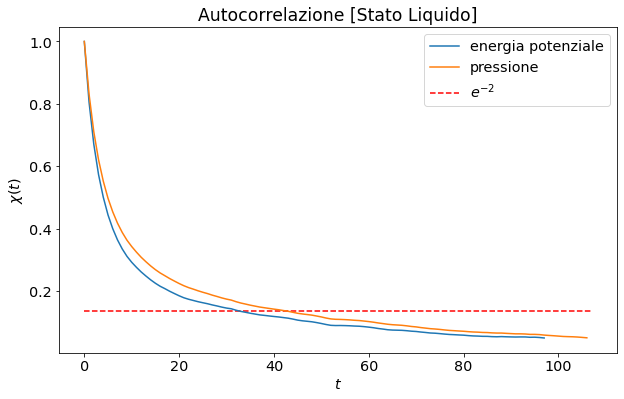

In [8]:
plot_autocorr(energia_l,pressione_l,"Liquido")

<div style="font-size: 0.43cm;">
Nella simulazione dello stato liquido la correlazione cala più lentamente del caso dello stato solido. Prendendo come soglia di non-correlazione $e^{-2}$, ci vogliono circa 35 step per l'energia potenziale e 45 per la pressione per avere misure indipendenti.
</div>

varianza: 0.0026602288389265816
varianza: 6.107246851948288e-05


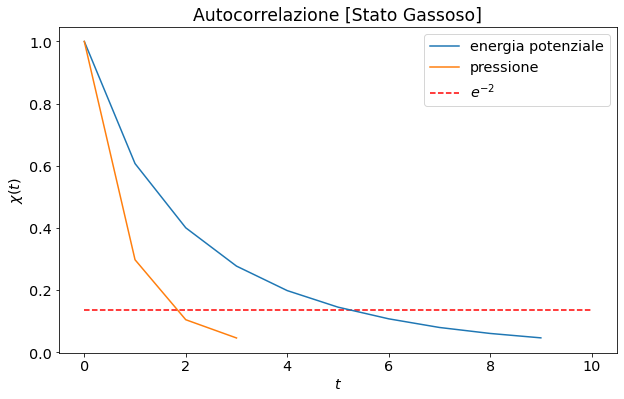

In [9]:
plot_autocorr(energia_g,pressione_g,"Gassoso")

<div style="font-size: 0.43cm;">
Nella simulazione dello stato gassoso l'autocorrelazione cala immediatamente: bastano 5 timestep per avere misure di energia potenziale e pressione indipendenti.
</div>

<div style="color:#555555; font-size: 0.7cm; font-weight:bold;">Punto 2</div>

<div style="color:#333333; font-size: 0.43cm; padding: 1em; background-color:#F5F5F5">
Utilizzare gli stessi dati per stimare l'incertezza statistica finale in funzione della dimensione dei blocchi $L$ tra $10$ e $5000$.
</div>

In [10]:
def blocchi_sigma_finale(data,L):
    i = 0
    N = int(len(data)/L)
    
    block = np.zeros(N)
    
    for i in range(N):
        
        par_sum = 0
        for j in range(L):
            par_sum = par_sum + data[L*i+j]
        
        block[i] = par_sum/L

    mean = 0
    mean2 = 0

    for j in range (N):
        mean += block[j] / N
        mean2 += block[j]**2 / N

    sigma = np.sqrt((mean2 - mean**2)/(N-1))
    ave = mean
    
    return sigma

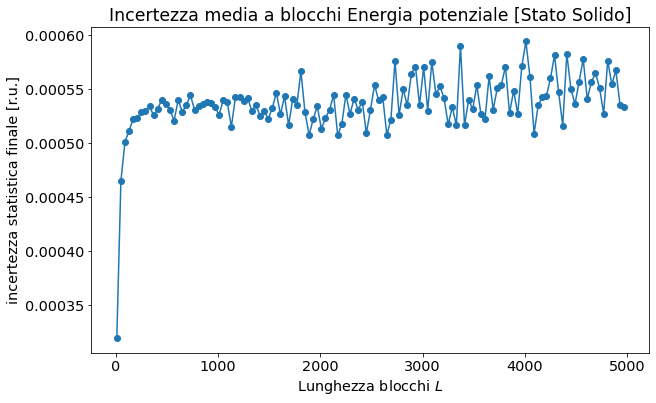

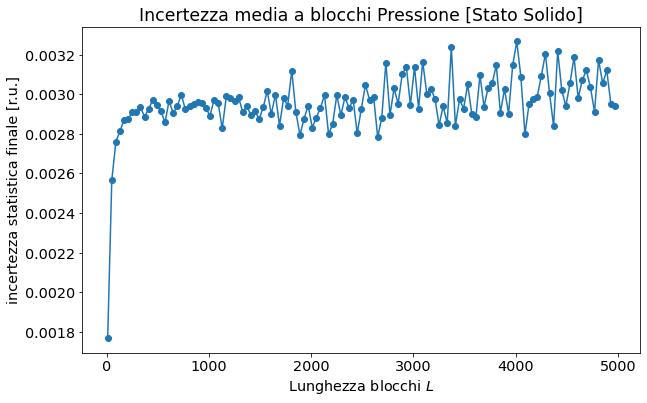

In [11]:
Ls = [40*r+10 for r in range(125)]
sigmas = []
for L in Ls:
    val = blocchi_sigma_finale(energia_s,L)
    sigmas.append(val)
plt.plot(Ls,sigmas,'o-')
plt.title("Incertezza media a blocchi Energia potenziale [Stato Solido]")
plt.xlabel("Lunghezza blocchi $L$")
plt.ylabel("incertezza statistica finale [r.u.]")
plt.show()

sigmas = []
for L in Ls:
    val = blocchi_sigma_finale(pressione_s,L)
    sigmas.append(val)
plt.plot(Ls,sigmas,'o-')
plt.title("Incertezza media a blocchi Pressione [Stato Solido]")
plt.xlabel("Lunghezza blocchi $L$")
plt.ylabel("incertezza statistica finale [r.u.]")
plt.show()

<div style="font-size: 0.43cm;">
Inizialmente, per la simulazione dello stato solido, al crescere della taglia dei blocchi, cresce molto rapidamente anche l'incertezza statistica di entrambe le variabili termodinamiche; ad un certo punto viene raggiunta una taglia (attorno a $300$) oltre la quale l'incertezza statistica non sembra più aumentare, ma oscillare attorno ad un valore costante (circa $0.00053$ per l'energia potenziale e circa $0.00295$ per la pressione).
</div>

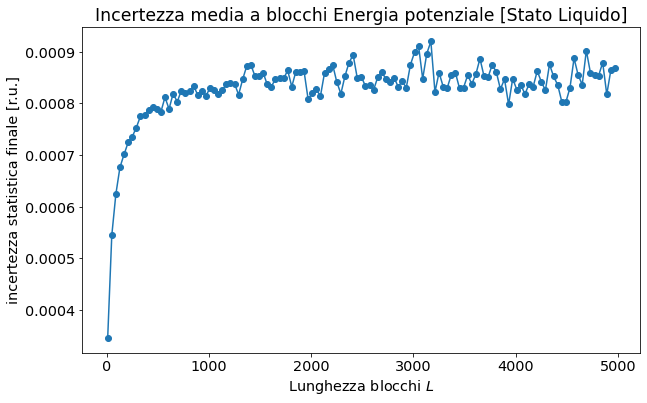

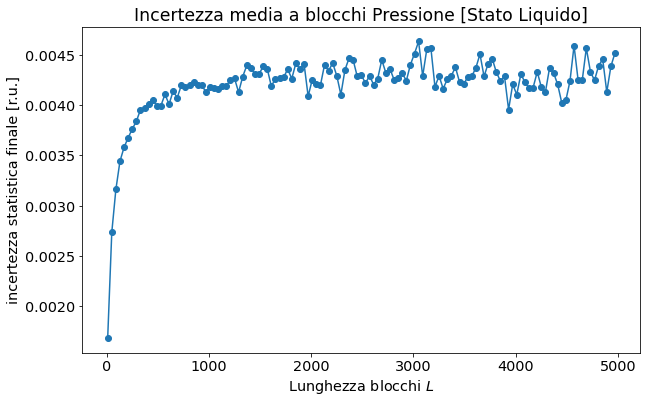

In [12]:
Ls = [40*r+10 for r in range(125)]
sigmas = []
for L in Ls:
    val = blocchi_sigma_finale(energia_l,L)
    sigmas.append(val)
plt.plot(Ls,sigmas,'o-')
plt.title("Incertezza media a blocchi Energia potenziale [Stato Liquido]")
plt.xlabel("Lunghezza blocchi $L$")
plt.ylabel("incertezza statistica finale [r.u.]")
plt.show()

sigmas = []
for L in Ls:
    val = blocchi_sigma_finale(pressione_l,L)
    sigmas.append(val)
plt.plot(Ls,sigmas,'o-')
plt.title("Incertezza media a blocchi Pressione [Stato Liquido]")
plt.xlabel("Lunghezza blocchi $L$")
plt.ylabel("incertezza statistica finale [r.u.]")
plt.show()

<div style="font-size: 0.43cm;">
Anche nella simulazione dello stato liquido è ben visibile il progressivo assestamento dell'incertezza statistica dal basso verso un valore costante (di circa $0.0007$ per l'energia potenziale e $0.0042$ per la pressione). La taglia a cui l'incertezza smette di crescere (attorno a $1000$) è maggiore che nel caso dello stato solido, esattamente come la funzione di correlazione dello stato liquido calava più lentamente che quella dello stato solido.
</div>

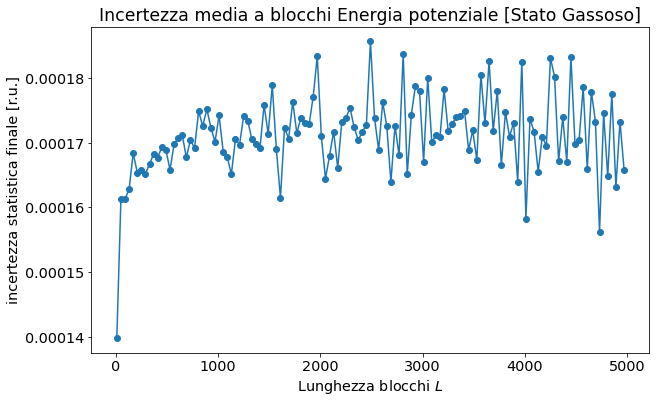

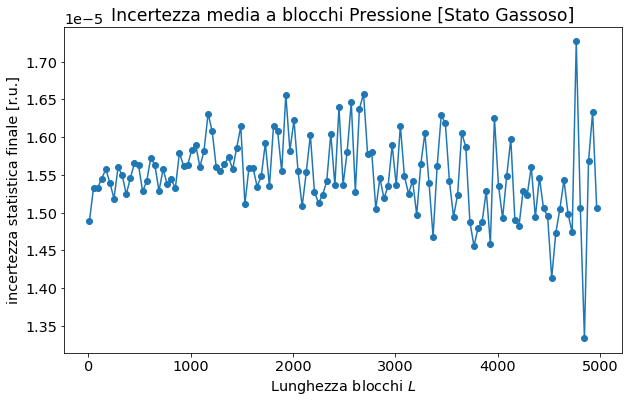

In [13]:
Ls = [40*r+10 for r in range(125)]
sigmas = []
for L in Ls:
    val = blocchi_sigma_finale(energia_g,L)
    sigmas.append(val)
plt.plot(Ls,sigmas,'o-')
plt.title("Incertezza media a blocchi Energia potenziale [Stato Gassoso]")
plt.xlabel("Lunghezza blocchi $L$")
plt.ylabel("incertezza statistica finale [r.u.]")
plt.show()

sigmas = []
for L in Ls:
    val = blocchi_sigma_finale(pressione_g,L)
    sigmas.append(val)
plt.plot(Ls,sigmas,'o-')
plt.title("Incertezza media a blocchi Pressione [Stato Gassoso]")
plt.xlabel("Lunghezza blocchi $L$")
plt.ylabel("incertezza statistica finale [r.u.]")
plt.show()

<div style="font-size: 0.43cm;">
Per lo stato gassoso bastano blocchi molto più piccoli (lunghezza di circa $200$) per avere incertezza statistica costante.
</div>

<div style="color:#333333; font-size: 0.43cm; padding: 1em; background-color:#F5F5F5">
Cosa si osserva sull'andamento dell'incertezza statistica per dimensioni dei blocchi abbastanza grandi?
</div>

<div style="font-size: 0.43cm;">
In tutti i casi si è notato che, dopo una certa soglia che dipende da caso a caso, l'incertezza statistica oscilla attorno ad un valore indipendente dalla taglia del blocco.
</div>

<div style="color:#180090; font-size: 0.9cm; padding-top: 1em; font-weight:bold;">Esercizio 2</div>

<div style="color:#333333; font-size: 0.43cm; padding: 1em; background-color:#F5F5F5">
Includere nell'algoritmo il calcolo della funzione di distribuzione radiale $g(r)$ delle distanze tra coppie di particelle con $r\in[0,L/2]$.
</div>

<div style="font-size: 0.43cm;">
Per valutare la funzione di distribuzione radiale, ad ogni misura, si valuta per ogni coppia di particelle la distanza reciproca; se questa distanza è inferiore a $L/2$, si aumenta il contatore del bin corrispondente.

Le shell di spessore pari alla dimensione di ogni bin $dr$ e di raggio (interno) $r$ ha un volume che dipende ovviamente da $r$. Pertanto, il numero di conteggi fatto in ogni bin deve essere normalizzato per il volume della shell di raggio corrispondente a quel bin:
    
$$\dfrac{4\pi}{3}((r+dr)^3 - r^3).$$
    
</div>

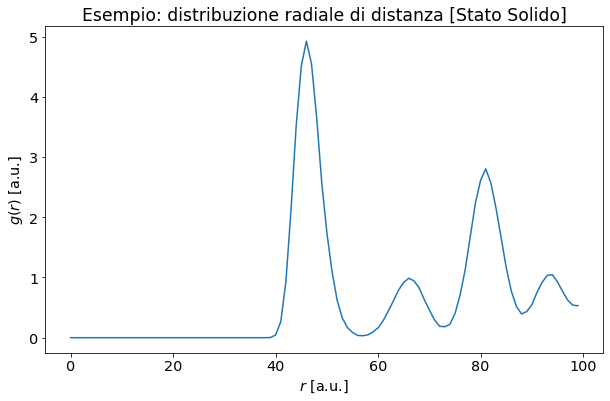

In [14]:
tutto = np.loadtxt("results/output.gofr.solid.NVT")
plt.plot(tutto[:][0])
plt.title("Esempio: distribuzione radiale di distanza [Stato Solido]")
plt.xlabel("$r$ [a.u.]")
plt.ylabel("$g(r)$ [a.u.]")
plt.show()

<div style="font-size: 0.43cm;">
In questo esempio di distribuzione radiale di distanza per una simulazione di stato solido, si notano dei picchi ben localizzati di diversa altezza. Questa struttura non banale evidenzia la presenza di un reticolo cristallino ordinato. Inoltre, si nota che per piccoli $r$ la funzione è prossima allo zero. Questo effetto è dovuto alla dominante repulsione nel potenziale di Lennard-Jones per piccoli $\frac{r}{\sigma}$.
</div>

<div style="color:#180090; font-size: 0.9cm; padding-top: 1em; font-weight:bold;">Esercizio 3</div>

<div style="color:#333333; font-size: 0.43cm; padding: 1em; background-color:#F5F5F5">
Includere il calcolo di $g(r)$ anche nel codice di dinamica molecolare utilizzato nell'Esercitazione 4.
</div>

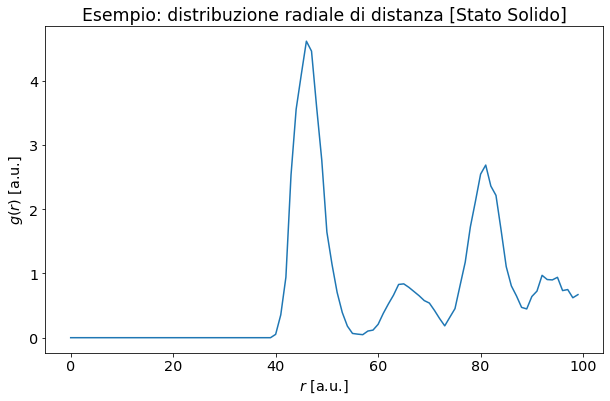

In [15]:
tutto = np.loadtxt("results/output.gofr.solid.MD")
plt.plot(tutto[:][-1])
plt.title("Esempio: distribuzione radiale di distanza [Stato Solido]")
plt.xlabel("$r$ [a.u.]")
plt.ylabel("$g(r)$ [a.u.]")
plt.show()

<div style="font-size: 0.43cm;">
Viene inserito il calcolo di $g(r)$ anche nel codice di dinamica molecolare e si osserva la somiglianza con il grafico precedente.
</div>

<div style="color:#180090; font-size: 0.9cm; padding-top: 1em; font-weight:bold;">Esercizio 4</div>

<div style="color:#333333; font-size: 0.43cm; padding: 1em; background-color:#F5F5F5">
Eseguire delle simulazioni di un sistema secondo il modello di Lennard-Jones utilizzando Argon:

- $\sigma = 0.34 \text{ nm}$
- $\epsilon/k_B = 120 \text{ K}$
- $m=39.948 \text{ a.m.u.}$

nelle tre condizioni termodinamiche dell'Esercizio 1.
    
Confrontare i risultati ottenuti con gli algoritmi di dinamica molecolare e NVT Monte Carlo.
</div>

In [16]:
u_energia_in_Kb = 120
u_energia = 1.38065E-23 * u_energia_in_Kb
u_lunghezza = 3.4E-10

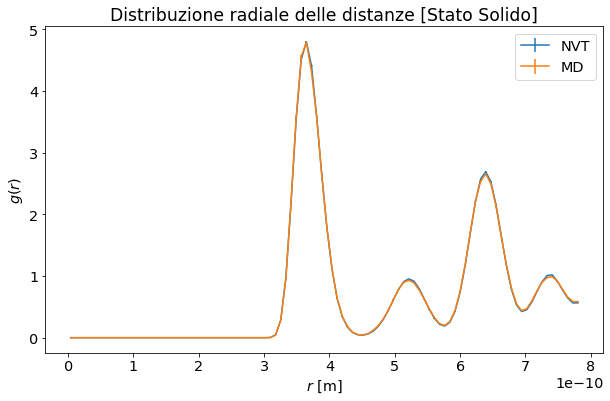

In [17]:
r,g,sigma = np.loadtxt("results/output.gave.solid.NVT", usecols=(0,1,2), unpack='true')
plt.errorbar(r*u_lunghezza,g,yerr=sigma,label="NVT")

r,g,sigma = np.loadtxt("results/output.gave.solid.MD", usecols=(0,1,2), unpack='true')
plt.errorbar(r*u_lunghezza,g,yerr=sigma,label="MD")

plt.title("Distribuzione radiale delle distanze [Stato Solido]")
plt.xlabel("$r$ [m]")
plt.ylabel("$g(r)$")
plt.legend()
plt.show()

<div style="font-size: 0.43cm;">
Le funzioni di distribuzione radiale delle distanze estratte dalle simulazioni per lo stato solido NTV Monte Carlo e dinamica molecolare sono perfettamente sovrapponibili.
</div>

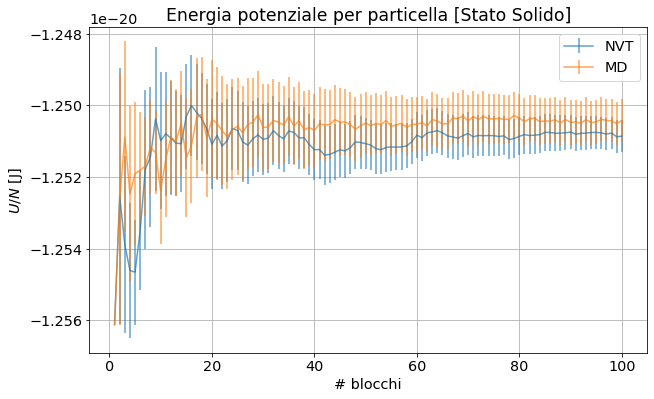

In [18]:
blk,mean,sigma = np.loadtxt("results/output.epot.solid.NVT", usecols=(0,2,3), unpack='true')
plt.errorbar(blk,mean*u_energia,yerr=sigma*u_energia,alpha=0.7,label="NVT")

mean,sigma = np.loadtxt("results/output.epot.solid.MD", usecols=(0,1), unpack='true')
plt.errorbar(blk,mean*u_energia,yerr=sigma*u_energia,alpha=0.7,label="MD")

plt.title("Energia potenziale per particella [Stato Solido]")
plt.xlabel("# blocchi")
plt.ylabel("$U/N$ [J]")
plt.grid()
plt.legend()
plt.show()

<div style="font-size: 0.43cm;">
Le misure di energia potenziale per particella sono totalmente compatibili.
</div>

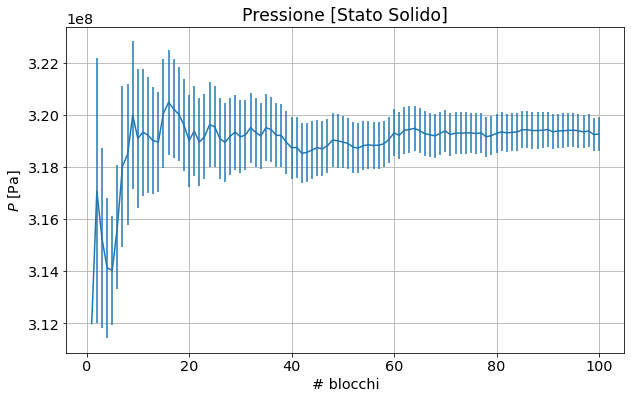

In [19]:
blk, mean,sigma = np.loadtxt("results/output.pres.solid.NVT",  usecols=(0,2,3), unpack='true')
plt.errorbar(blk,mean*u_energia/(u_lunghezza**3),yerr=sigma*u_energia/(u_lunghezza**3))
plt.title("Pressione [Stato Solido]")
plt.xlabel("# blocchi")
plt.ylabel("$P$ [Pa]")
plt.grid()
plt.show()

<div style="font-size: 0.43cm;">
La pressione media è $3.193 \times 10^8 \pm 6 \times 10^5 \text{ Pa}$
</div>

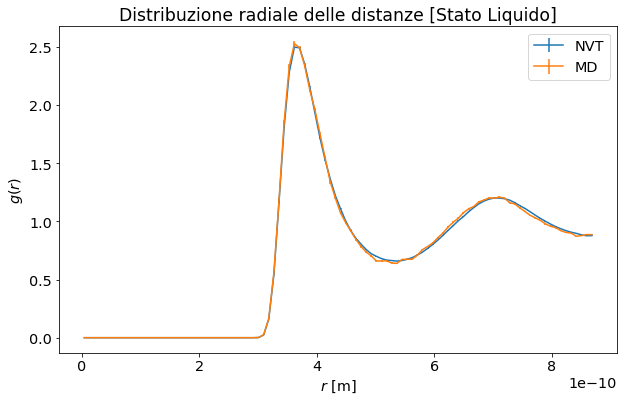

In [20]:
r,g,sigma = np.loadtxt("results/output.gave.liquid.NVT", usecols=(0,1,2), unpack='true')
plt.errorbar(r*u_lunghezza,g,yerr=sigma,label="NVT")

r,g,sigma = np.loadtxt("results/output.gave.liquid.MD", usecols=(0,1,2), unpack='true')
plt.errorbar(r*u_lunghezza,g,yerr=sigma,label="MD")

plt.title("Distribuzione radiale delle distanze [Stato Liquido]")
plt.xlabel("$r$ [m]")
plt.ylabel("$g(r)$")
plt.legend()
plt.show()

<div style="font-size: 0.43cm;">
Le funzioni di distribuzione radiale delle distanze estratte dalle simulazioni per lo stato liquido NTV Monte Carlo e dinamica molecolare sono perfettamente sovrapponibili.
</div>

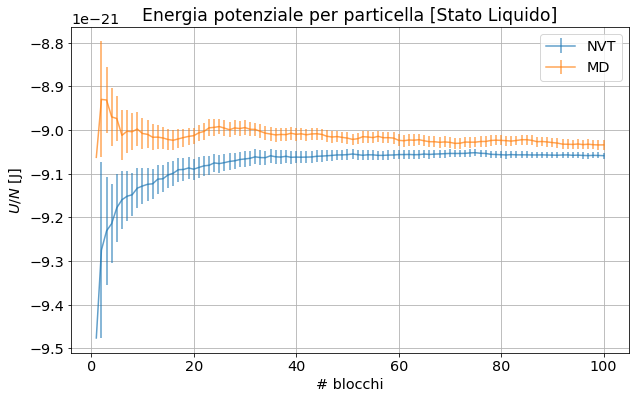

In [21]:
blk,mean,sigma = np.loadtxt("results/output.epot.liquid.NVT", usecols=(0,2,3), unpack='true')
plt.errorbar(blk,mean*u_energia,yerr=sigma*u_energia,alpha=0.7,label="NVT")

mean,sigma = np.loadtxt("results/output.epot.liquid.MD", usecols=(0,1), unpack='true')
plt.errorbar(blk,mean*u_energia,yerr=sigma*u_energia,alpha=0.7,label="MD")

plt.title("Energia potenziale per particella [Stato Liquido]")
plt.xlabel("# blocchi")
plt.ylabel("$U/N$ [J]")
plt.grid()
plt.legend()
plt.show()

<div style="font-size: 0.43cm;">
Le misure di energia potenziale per particella sono compatibili entro $2$ sigma.
</div>

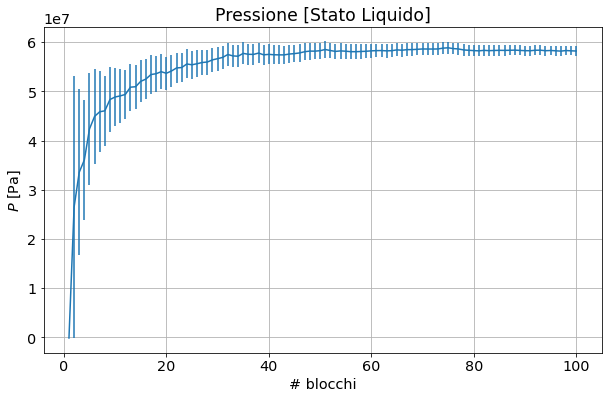

In [22]:
blk, mean,sigma = np.loadtxt("results/output.pres.liquid.NVT",  usecols=(0,2,3), unpack='true')
plt.errorbar(blk,mean*u_energia/(u_lunghezza**3),yerr=sigma*u_energia/(u_lunghezza**3))
plt.title("Pressione [Stato Liquido]")
plt.xlabel("# blocchi")
plt.ylabel("$P$ [Pa]")
plt.grid()
plt.show()

<div style="font-size: 0.43cm;">
La pressione media è $5.82 \times 10^7 \pm 9 \times 10^5 \text{ Pa}$
</div>

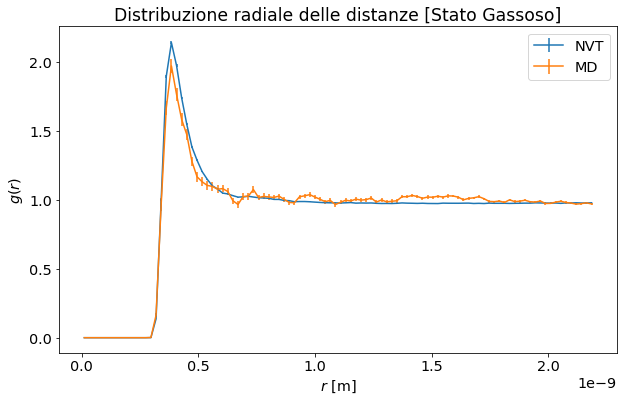

In [23]:
r,g,sigma = np.loadtxt("results/output.gave.gas.NVT", usecols=(0,1,2), unpack='true')
plt.errorbar(r*u_lunghezza,g,yerr=sigma,label="NVT")

r,g,sigma = np.loadtxt("results/output.gave.gas.MD", usecols=(0,1,2), unpack='true')
plt.errorbar(r*u_lunghezza,g,yerr=sigma,label="MD")

plt.title("Distribuzione radiale delle distanze [Stato Gassoso]")
plt.xlabel("$r$ [m]")
plt.ylabel("$g(r)$")
plt.legend()
plt.show()

<div style="font-size: 0.43cm;">
Le funzioni di distribuzione radiale delle distanze estratte dalle simulazioni per lo stato gassoso NTV Monte Carlo e dinamica molecolare hanno discrepanze di qualche sigma in diversi punti. La causa è principalmente la "ruvidezza" della distribuzione calcolata dalla simulazione di dinamica molecolare. La forma, comunque, è la stessa.
</div>

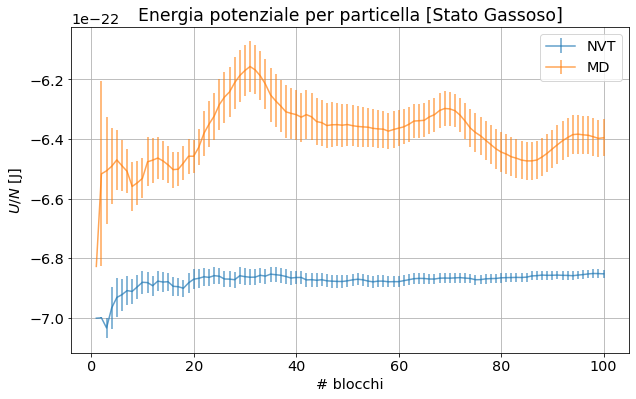

In [24]:
blk,mean,sigma = np.loadtxt("results/output.epot.gas.NVT", usecols=(0,2,3), unpack='true')
plt.errorbar(blk,mean*u_energia,yerr=sigma*u_energia,alpha=0.7,label="NVT")

mean,sigma = np.loadtxt("results/output.epot.gas.MD", usecols=(0,1), unpack='true')
plt.errorbar(blk,mean*u_energia,yerr=sigma*u_energia,alpha=0.7,label="MD")

plt.title("Energia potenziale per particella [Stato Gassoso]")
plt.xlabel("# blocchi")
plt.ylabel("$U/N$ [J]")
plt.grid()
plt.legend()
plt.show()

<div style="font-size: 0.43cm;">
Le misure di energia potenziale per particella non sono compatibili. Una motivazione di ciò può essere il fatto che la temperatura del gas non riesce ad essere stabile a $1.2$ nell'algoritmo di dinamica molecolare.
</div>

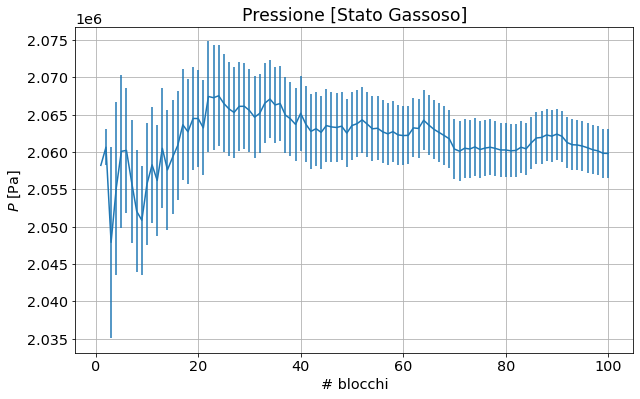

In [25]:
blk, mean,sigma = np.loadtxt("results/output.pres.gas.NVT",  usecols=(0,2,3), unpack='true')
plt.errorbar(blk,mean*u_energia/(u_lunghezza**3),yerr=sigma*u_energia/(u_lunghezza**3))
plt.title("Pressione [Stato Gassoso]")
plt.xlabel("# blocchi")
plt.ylabel("$P$ [Pa]")
plt.grid()
plt.show()

<div style="font-size: 0.43cm;">
La pressione media è $2.060 \times 10^6 \pm 3 \times 10^3 \text{ Pa}$
</div>